# Network Traffic Forecasting with _AutoTS_

In telco, accurate forecast of KPIs (e.g. network traffic, utilizations, user experience, etc.) for communication networks ( 2G/3G/4G/5G/wired) can help predict network failures, allocate resource, or save energy. 

In this notebook, we demostrate a reference use case where we use the network traffic KPI(s) in the past to predict traffic KPI(s) in the future. We demostrate how to use `AutoTS` in project [Zouwu](https://github.com/intel-analytics/analytics-zoo/tree/master/pyzoo/zoo/zouwu) to do time series forecasting in an automated and distributed way.

For demonstration, we use the publicly available network traffic data repository maintained by the [WIDE project](http://mawi.wide.ad.jp/mawi/) and in particular, the network traffic traces aggregated every 2 hours (i.e. AverageRate in Mbps/Gbps and Total Bytes) in year 2018 and 2019 at the transit link of WIDE to the upstream ISP ([dataset link](http://mawi.wide.ad.jp/~agurim/dataset/)). 

## Helper functions

This section defines some helper functions to be used in the following procedures. You can refer to it later when they're used.

In [1]:
def get_drop_dates_and_len(df, allow_missing_num=3):
    """
    Find missing values and get records to drop
    """
    missing_num = df.total.isnull().astype(int).groupby(df.total.notnull().astype(int).cumsum()).sum()
    drop_missing_num = missing_num[missing_num > allow_missing_num]
    drop_datetimes = df.iloc[drop_missing_num.index].index
    drop_len = drop_missing_num.values
    return drop_datetimes, drop_len

In [2]:
def rm_missing_weeks(start_dts, missing_lens, df):
    """
    Drop weeks that contains more than 3 consecutive missing values.
    If consecutive missing values across weeks, we remove all the weeks.
    """ 
    for start_time, l in zip(start_dts, missing_lens):
        start = start_time - pd.Timedelta(days=start_time.dayofweek)
        start = start.replace(hour=0, minute=0, second=0)
        start_week_end = start + pd.Timedelta(days=6)
        start_week_end = start_week_end.replace(hour=22, minute=0, second=0)

        end_time = start_time + l*pd.Timedelta(hours=2)
        if start_week_end < end_time:
            end = end_time + pd.Timedelta(days=6-end_time.dayofweek)
            end = end.replace(hour=22, minute=0, second=0)
        else:
            end = start_week_end
        df = df.drop(df[start:end].index)
    return df

In [3]:
# plot the predicted values and actual values (for the test data)
def plot_result(test_df, pred_df, dt_col="datetime", value_col="AvgRate", look_back=1):
    # target column of dataframe is "value"
    # past sequence length is 50
    pred_value = pred_df[value_col].values
    true_value = test_df[value_col].values[look_back:]
    fig, axs = plt.subplots(figsize=(12, 5))

    axs.plot(pred_df[dt_col], pred_value, color='red', label='predicted values')
    axs.plot(test_df[dt_col][look_back:], true_value, color='blue', label='actual values')
    axs.set_title('the predicted values and actual values (for the test data)')

    plt.xlabel(dt_col)
    plt.xticks(rotation=45)
    plt.ylabel(value_col)
    plt.legend(loc='upper left')
    plt.show()

## Download raw dataset and load into dataframe

Now we download the dataset and load it into a pandas dataframe. Steps are as below. 

* First, run the script `get_data.sh` to download the raw data. It will download the monthly aggregated traffic data in year 2018 and 2019 into `data` folder. The raw data contains aggregated network traffic (average MBPs and total bytes) as well as other metrics. 

* Second, run `extract_data.sh` to extract relavant traffic KPI's from raw data, i.e. `AvgRate` for average use rate, and `total` for total bytes. The script will extract the KPI's with timestamps into `data/data.csv`.

* Finally, use pandas to load `data/data.csv` into a dataframe as shown below

In [4]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
raw_df = pd.read_csv("data/data.csv")

Below are some example records of the data

In [6]:
raw_df.head()

,StartTime,EndTime,AvgRate,total
0,2018/01/01 00:00:00,2018/01/01 02:00:00,306.23Mbps,275605455598
1,2018/01/01 02:00:00,2018/01/01 04:00:00,285.03Mbps,256527692256
2,2018/01/01 04:00:00,2018/01/01 06:00:00,247.39Mbps,222652190823
3,2018/01/01 06:00:00,2018/01/01 08:00:00,211.55Mbps,190396029658
4,2018/01/01 08:00:00,2018/01/01 10:00:00,234.82Mbps,211340468977


## Data pre-processing

Now we need to do data cleaning and preprocessing on the raw data. Note that this part could vary for different dataset. 

For the network traffic data we're using, the processing contains 3 parts:
1. Convert string datetime to TimeStamp
2. Unify the measurement scale for `AvgRate` value - some uses Mbps, some uses Gbps 
3. Handle missing data (fill or drop).

In [7]:
df = pd.DataFrame(pd.to_datetime(raw_df.StartTime))

In [8]:
# we can find 'AvgRate' is of two scales: 'Mbps' and 'Gbps' 
raw_df.AvgRate.str[-4:].unique()

array(['Mbps', 'Gbps'], dtype=object)

In [9]:
# Unify AvgRate value
df['AvgRate'] = raw_df.AvgRate.apply(lambda x: float(x[:-4]) if x.endswith("Mbps") else float(x[:-4]) * 1000)

In [10]:
df["total"] = raw_df["total"]
df.set_index("StartTime", inplace=True)

In [11]:
full_idx = pd.date_range(start=df.index.min(), end=df.index.max(), freq='2H')
df = df.reindex(full_idx)
print("no. of n/a values:")
print(df.isna().sum())

no. of n/a values:
AvgRate    3
total      3
dtype: int64


Here, we drop weeks with more than 3 consecutive missing values and fill other missing values remained.

In [12]:
drop_dts, drop_len = get_drop_dates_and_len(df)
df = rm_missing_weeks(drop_dts, drop_len, df)

In [13]:
df.ffill(inplace=True)

In [14]:
# AutoTS requires input data frame with a datetime column
df.index.name = "datetime"
df = df.reset_index()

In [15]:
df.head()

,datetime,AvgRate,total
0,2018-01-01 00:00:00,306.23,2.756055e+11
1,2018-01-01 02:00:00,285.03,2.565277e+11
2,2018-01-01 04:00:00,247.39,2.226522e+11
3,2018-01-01 06:00:00,211.55,1.903960e+11
4,2018-01-01 08:00:00,234.82,2.113405e+11


In [16]:
df.describe()

,AvgRate,total
count,8760.000000,8.760000e+03
mean,454.050030,4.084920e+11
std,238.377074,2.146655e+11
min,86.490000,8.641890e+09
25%,273.715000,2.459111e+11
50%,410.590000,3.694360e+11
75%,558.200000,5.023054e+11
max,1760.000000,1.585238e+12


Plot the data to see how the KPI's look like

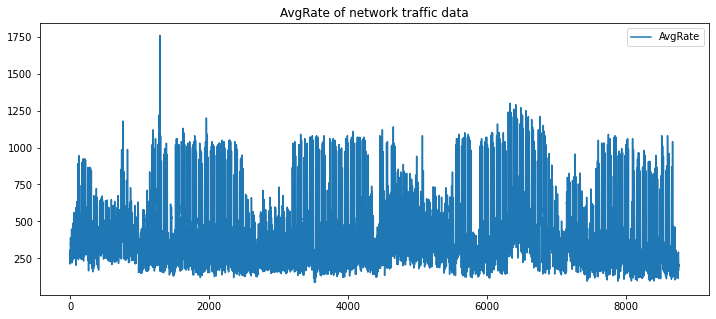

In [17]:
ax = df.plot(y='AvgRate',figsize=(12,5), title="AvgRate of network traffic data")

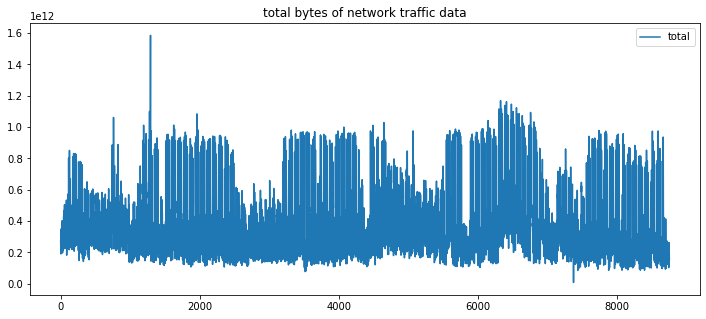

In [18]:
ax = df.plot(y='total',figsize=(12,5), title="total bytes of network traffic data")

## Time series forecasting with _AutoTS_

_AutoTS_ provides AutoML support for building end-to-end time series analysis pipelines (including automatic feature generation, model selection and hyperparameter tuning).

The general workflow using automated training contains below two steps. 
   1. create a ```AutoTSTrainer``` to train a ```TSPipeline```, save it to file to use later or elsewhere if you wish.
   2. use ```TSPipeline``` to do prediction, evaluation, and incremental fitting as well. 


First, you need to initialize RayOnSpark before using auto training (i.e. ```AutoTSTrainer```), and stop it after training finished. (Note RayOnSpark is not needed if you just use `TSPipeline` for inference, evaluation or incremental training.)


In [19]:
# init RayOnSpark in local mode
from zoo import init_spark_on_local
from zoo.ray import RayContext
sc = init_spark_on_local(cores=4, spark_log_level="INFO")
ray_ctx = RayContext(sc=sc, object_store_memory="1g")
ray_ctx.init()

/home/shane/.local/lib/python3.6/site-packages/bigdl/util/engine.py:41: UserWarning: Find both SPARK_HOME and pyspark. You may need to check whether they match with each other. SPARK_HOME environment variable is set to: /home/shane/shane/spark, and pyspark is found in: /home/shane/anaconda3/envs/automl/lib/python3.6/site-packages/pyspark/__init__.py. If they are unmatched, please use one source only to avoid conflict. For example, you can unset SPARK_HOME and use pyspark only.
  warnings.warn(warning_msg)
/home/shane/anaconda3/envs/automl/lib/python3.6/site-packages/zoo/util/engine.py:42: UserWarning: Find both SPARK_HOME and pyspark. You may need to check whether they match with each other. SPARK_HOME environment variable is set to: /home/shane/shane/spark, and pyspark is found in: /home/shane/anaconda3/envs/automl/lib/python3.6/site-packages/pyspark/__init__.py. If they are unmatched, you are recommended to use one source only to avoid conflict. For example, you can unset SPARK_HOME 

Prepending /home/shane/.local/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
Adding /home/shane/anaconda3/envs/automl/lib/python3.6/site-packages/zoo/share/lib/analytics-zoo-bigdl_0.10.0-spark_2.4.3-0.8.0-SNAPSHOT-jar-with-dependencies.jar to BIGDL_JARS
Prepending /home/shane/anaconda3/envs/automl/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
Current pyspark location is : /home/shane/anaconda3/envs/automl/lib/python3.6/site-packages/pyspark/__init__.py
Start to getOrCreate SparkContext
Successfully got a SparkContext
Start to launch the JVM guarding process
JVM guarding process has been successfully launched
Start to launch ray on cluster
Start to launch ray on local


Then we initialize a `AutoTSTrainer`.
* `dt_col`: the column specifying datetime.
* `target_col`: target column to predict. Here, we take `AvgRate` KPI as an example.
* `horizon` : num of steps to look forward. 
* `extra_feature_col`: a list of columns which are also included in input data frame as features except target column.

In [20]:
from zoo.zouwu.autots.forecast import AutoTSTrainer

trainer = AutoTSTrainer(dt_col="datetime",
                        target_col="AvgRate",
                        horizon=1,
                        extra_features_col=None)

We can set some searching presets such as `look_back` which indicates the history time period we want to use for forecasting.
lookback can be an int which it is a fixed values, or can be a tuple to indicate the range for sampling.

In [21]:
# look back in range from one week to 3 days to predict the next 2h.
look_back = (36, 84)

We need to split the data frame into train, validation and test data frame before training. You can use `split_input_df` as an easy way to finish it.

In [22]:
from zoo.automl.common.util import split_input_df
train_df, val_df, test_df = split_input_df(df, ts_col="datetime", 
                                           overlap=look_back[0],
                                           val_split_ratio=0.1, 
                                           test_split_ratio=0.1)

Then we fit on train data and validation data. 

You can use `recipe` to specify searching method as well as other searching presets such as stop criteria .etc. The `GridRandomRecipe` here is a recipe that combines grid search with random search to find the best set of parameters. For more details, please refer to analytics-zoo document [here](https://analytics-zoo.github.io/master/#APIGuide/AutoML/recipe/).

In [23]:
from zoo.automl.config.recipe import LSTMGridRandomRecipe

In [25]:
%%time
ts_pipeline = trainer.fit(train_df, val_df, 
                          recipe=LSTMGridRandomRecipe(
                              num_rand_samples=1,
                              epochs=1,
                              look_back=look_back, 
                              batch_size=[64]),
                          metric="mse")

2020-04-05 17:45:31,476	INFO tune.py:60 -- Tip: to resume incomplete experiments, pass resume='prompt' or resume=True to run()
2020-04-05 17:45:31,477	INFO tune.py:223 -- Starting a new experiment.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 2.2/16.6 GB



== Status ==
Using FIFO scheduling algorithm.
Resources requested: 2/4 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 2.2/16.6 GB
Result logdir: /home/shane/ray_results/automl
Number of trials: 3 ({'RUNNING': 1, 'PENDING': 2})
PENDING trials:
 - train_func_1_batch_size=64,dropout_2=0.41106,lr=0.0094198,lstm_1_units=128,lstm_2_units=32,past_seq_len=74,selected_features=['WEEKDAY(datetime)' 'IS_WEEKEND(datetime)' 'MONTH(datetime)'
 'IS_AWAKE(datetime)' 'HOUR(datetime)' 'DAY(datetime)']:	PENDING
 - train_func_2_batch_size=64,dropout_2=0.25682,lr=0.009007,lstm_1_units=16,lstm_2_units=64,past_seq_len=40,selected_features=['WEEKDAY(datetime)' 'DAY(datetime)' 'IS_AWAKE(datetime)'
 'MONTH(datetime)']:	PENDING
RUNNING trials:
 - train_func_0_batch_size=64,dropout_2=0.39015,lr=0.0055474,lstm_1_units=16,lstm_2_units=16,past_

(pid=9184) 2020-04-05 17:45:32,982	WARNING worker.py:204 -- Calling ray.get or ray.wait in a separate thread may lead to deadlock if the main thread blocks on this thread and there are not enough resources to execute more tasks
(pid=9184) 2020-04-05 17:45:32,982	WARNING worker.py:204 -- Calling ray.get or ray.wait in a separate thread may lead to deadlock if the main thread blocks on this thread and there are not enough resources to execute more tasks
(pid=9184) LSTM is selected.
(pid=9184) LSTM is selected.
(pid=9119) LSTM is selected.
(pid=9119) WARNING:tensorflow:From /home/shane/.local/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
(pid=9119) Instructions for updating:
(pid=9119) If using Keras pass *_constraint arguments to layers.
(pid=9184) WARNING:tensorflow:From /home/shane/.local/


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 4/4 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 3.0/16.6 GB
Result logdir: /home/shane/ray_results/automl
Number of trials: 3 ({'RUNNING': 2, 'PENDING': 1})
PENDING trials:
 - train_func_2_batch_size=64,dropout_2=0.25682,lr=0.009007,lstm_1_units=16,lstm_2_units=64,past_seq_len=40,selected_features=['WEEKDAY(datetime)' 'DAY(datetime)' 'IS_AWAKE(datetime)'
 'MONTH(datetime)']:	PENDING
RUNNING trials:
 - train_func_0_batch_size=64,dropout_2=0.39015,lr=0.0055474,lstm_1_units=16,lstm_2_units=16,past_seq_len=73,selected_features=['DAY(datetime)' 'HOUR(datetime)' 'IS_WEEKEND(datetime)'
 'IS_BUSY_HOURS(datetime)' 'WEEKDAY(datetime)']:	RUNNING, [2 CPUs, 0 GPUs], [pid=9119], 13 s, 1 iter
 - train_func_1_batch_size=64,dropout_2=0.41106,lr=0.0094198,lstm_1_units=128,lstm_2_units=32,past_seq_len=74,selected_features=['WEEKDAY(datetime)' 'IS_WEEKEND(datetime)' 'MONTH(datetime)'
 'IS_AWAKE(datetime)' 'HOUR(dat

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 4/4 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 3.0/16.6 GB
Result logdir: /home/shane/ray_results/automl
Number of trials: 3 ({'RUNNING': 2, 'PENDING': 1})
PENDING trials:
 - train_func_2_batch_size=64,dropout_2=0.25682,lr=0.009007,lstm_1_units=16,lstm_2_units=64,past_seq_len=40,selected_features=['WEEKDAY(datetime)' 'DAY(datetime)' 'IS_AWAKE(datetime)'
 'MONTH(datetime)']:	PENDING
RUNNING trials:
 - train_func_0_batch_size=64,dropout_2=0.39015,lr=0.0055474,lstm_1_units=16,lstm_2_units=16,past_seq_len=73,selected_features=['DAY(datetime)' 'HOUR(datetime)' 'IS_WEEKEND(datetime)'
 'IS_BUSY_HOURS(datetime)' 'WEEKDAY(datetime)']:	RUNNING, [2 CPUs, 0 GPUs], [pid=9119], 94 s, 9 iter
 - train_func_1_batch_size=64,dropout_2=0.41106,lr=0.0094198,lstm_1_units=128,lstm_2_units=32,past_seq_len=74,selected_features=['WEEKDAY(datetime)' 'IS_WEEKEND(datetime)' 'MONTH(datetime)'
 'IS_AWAKE(datetime)' 'HOUR(date

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 4/4 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 3.0/16.6 GB
Result logdir: /home/shane/ray_results/automl
Number of trials: 3 ({'TERMINATED': 1, 'RUNNING': 2})
RUNNING trials:
 - train_func_1_batch_size=64,dropout_2=0.41106,lr=0.0094198,lstm_1_units=128,lstm_2_units=32,past_seq_len=74,selected_features=['WEEKDAY(datetime)' 'IS_WEEKEND(datetime)' 'MONTH(datetime)'
 'IS_AWAKE(datetime)' 'HOUR(datetime)' 'DAY(datetime)']:	RUNNING, [2 CPUs, 0 GPUs], [pid=9184], 112 s, 9 iter
 - train_func_2_batch_size=64,dropout_2=0.25682,lr=0.009007,lstm_1_units=16,lstm_2_units=64,past_seq_len=40,selected_features=['WEEKDAY(datetime)' 'DAY(datetime)' 'IS_AWAKE(datetime)'
 'MONTH(datetime)']:	RUNNING, [2 CPUs, 0 GPUs], [pid=9118], 18 s, 2 iter
TERMINATED trials:
 - train_func_0_batch_size=64,dropout_2=0.39015,lr=0.0055474,lstm_1_units=16,lstm_2_units=16,past_seq_len=73,selected_features=['DAY(datetime)' 'HOUR(datetim

2020-04-05 17:48:02,052	INFO ray_trial_executor.py:180 -- Destroying actor for trial train_func_2_batch_size=64,dropout_2=0.25682,lr=0.009007,lstm_1_units=16,lstm_2_units=64,past_seq_len=40,selected_features=['WEEKDAY(datetime)' 'DAY(datetime)' 'IS_AWAKE(datetime)'
 'MONTH(datetime)']. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 3.0/16.6 GB
Result logdir: /home/shane/ray_results/automl
Number of trials: 3 ({'TERMINATED': 3})
TERMINATED trials:
 - train_func_0_batch_size=64,dropout_2=0.39015,lr=0.0055474,lstm_1_units=16,lstm_2_units=16,past_seq_len=73,selected_features=['DAY(datetime)' 'HOUR(datetime)' 'IS_WEEKEND(datetime)'
 'IS_BUSY_HOURS(datetime)' 'WEEKDAY(datetime)']:	TERMINATED, [2 CPUs, 0 GPUs], [pid=9119], 104 s, 10 iter
 - train_func_1_batch_size=64,dropout_2=0.41106,lr=0.0094198,lstm_1_units=128,lstm_2_units=32,past_seq_len=74,selected_features=['WEEKDAY(datetime)' 'IS_WEEKEND(datetime)' 'MONTH(datetime)'
 'IS_AWAKE(datetime)' 'HOUR(datetime)' 'DAY(datetime)']:	TERMINATED, [2 CPUs, 0 GPUs], [pid=9184], 124 s, 10 iter
 - train_func_2_batch_size=64,dropout_2=0.25682,lr=0.009007,lstm_1_units=16,lstm_2_units=64,past_seq_len=40,selected_features=['WEEKDAY(datetime)' 'DA

We get a `TSPipeline` after training. Let's print the hyper paramters selected.
Note that `past_seq_len` is the lookback value that is automatically chosen

In [26]:
ts_pipeline.internal.config

{'mean': [470.45753424657534,
  15.558219178082192,
  11.0,
  0.2842465753424658,
  0.25,
  2.98972602739726],
 'scale': [237.54721125499952,
  8.827884346441833,
  6.904105059069326,
  0.45105483009113834,
  0.4330127018922193,
  2.000829603694729],
 'future_seq_len': 1,
 'dt_col': 'datetime',
 'target_col': 'AvgRate',
 'extra_features_col': None,
 'drop_missing': True,
 'model': 'LSTM',
 'metric': 'mean_squared_error',
 'batch_size': 64,
 'selected_features': ['DAY(datetime)',
  'HOUR(datetime)',
  'IS_WEEKEND(datetime)',
  'IS_BUSY_HOURS(datetime)',
  'WEEKDAY(datetime)'],
 'lstm_1_units': 16,
 'dropout_1': 0.2,
 'lstm_2_units': 16,
 'dropout_2': 0.39014785774361804,
 'lr': 0.005547442119849576,
 'epochs': 1,
 'past_seq_len': 73}

Use it to do prediction, evaluation or incremental fitting.

In [27]:
pred_df = ts_pipeline.predict(test_df)

plot actual and prediction values for `AvgRate` KPI

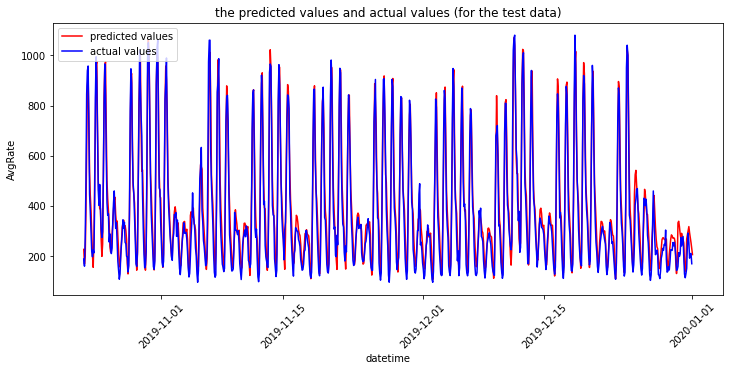

In [28]:
# plot the predicted values and actual values
plot_result(test_df, pred_df, dt_col="datetime", value_col="AvgRate", look_back=ts_pipeline.internal.config['past_seq_len'])

Calculate mean square error and the symetric mean absolute percentage error.

In [29]:
mse, smape = ts_pipeline.evaluate(test_df, metrics=["mse", "smape"])
print("Evaluate: the mean square error is", mse)
print("Evaluate: the smape value is", smape)

Evaluate: the mean square error is 3856.0159144400654
Evaluate: the smape value is 7.833294706287807


You can save the pipeline to file and reload it to do incremental fitting or others.

In [30]:
# save pipeline file
my_ppl_file_path = ts_pipeline.save("/tmp/saved_pipeline/my.ppl")

Pipeline is saved in /tmp/saved_pipeline/my.ppl


You can stop RayOnSpark after auto training.

In [31]:
# stop
ray_ctx.stop()
sc.stop()

Stopping pgids: [9079, 9167]
Stopping by pgid 9079
Stopping by pgid 9167


Next, we demonstrate how to do incremental fitting with your saved pipeline file.

First load saved pipeline file.

In [32]:
# load file
from zoo.zouwu.autots.forecast import TSPipeline
loaded_ppl = TSPipeline.load(my_ppl_file_path)

Restore pipeline from /tmp/saved_pipeline/my.ppl


Then do incremental fitting with `TSPipeline.fit()`.We use validation data frame as additional data for demonstration. You can use your new data frame.


In [36]:
# we use validation data frame as additional data for demonstration. 
loaded_ppl.fit(val_df, epochs=2)

Train on 839 samples
Epoch 1/2
839/839 [==============================] - 1s 807us/sample - loss: 0.1133 - mean_squared_error: 0.1133
Epoch 2/2
839/839 [==============================] - 1s 818us/sample - loss: 0.1005 - mean_squared_error: 0.1005
Fit done!


predict and plot the result after incremental fitting.

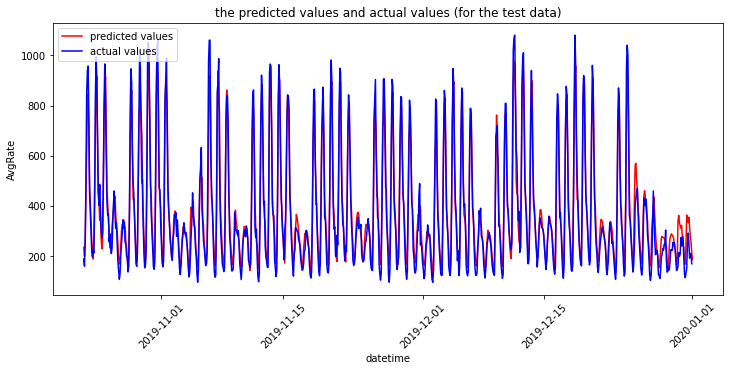

In [37]:
# predict results of test_df
new_pred_df = loaded_ppl.predict(test_df)
plot_result(test_df, new_pred_df, look_back=loaded_ppl.internal.config['past_seq_len'])

Calculate mean square error and the symetric mean absolute percentage error.

In [38]:
# evaluate test_df
mse, smape = loaded_ppl.evaluate(test_df, metrics=["mse", "smape"])
print("Evaluate: the mean square error is", mse)
print("Evaluate: the smape value is", smape)

Evaluate: the mean square error is 3488.6956947005465
Evaluate: the smape value is 7.372629462450104
